# Recurrent Neural Networks

## Univariate Time Series Regression

This notebook demonstrates how to forecast the S&P 500 index using a Recurrent Neural Network.

## Imports & Settings

In [107]:
import warnings
warnings.filterwarnings('ignore')

In [108]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
plt.rcParams['figure.dpi'] = 300

In [110]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [111]:
sns.set_style('whitegrid')
np.random.seed(42)
tf.random.set_seed(42)

In [112]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Get Data

We obtain data for 2010-2018 from the Federal Reserve Bank’s Data Service [FRED](https://fred.stlouisfed.org/) using the [pandas_datareader](https://pandas-datareader.readthedocs.io/) library in introduced in [Chapter 2 on Market and Fundamental Data](../02_market_and_fundamental_data).

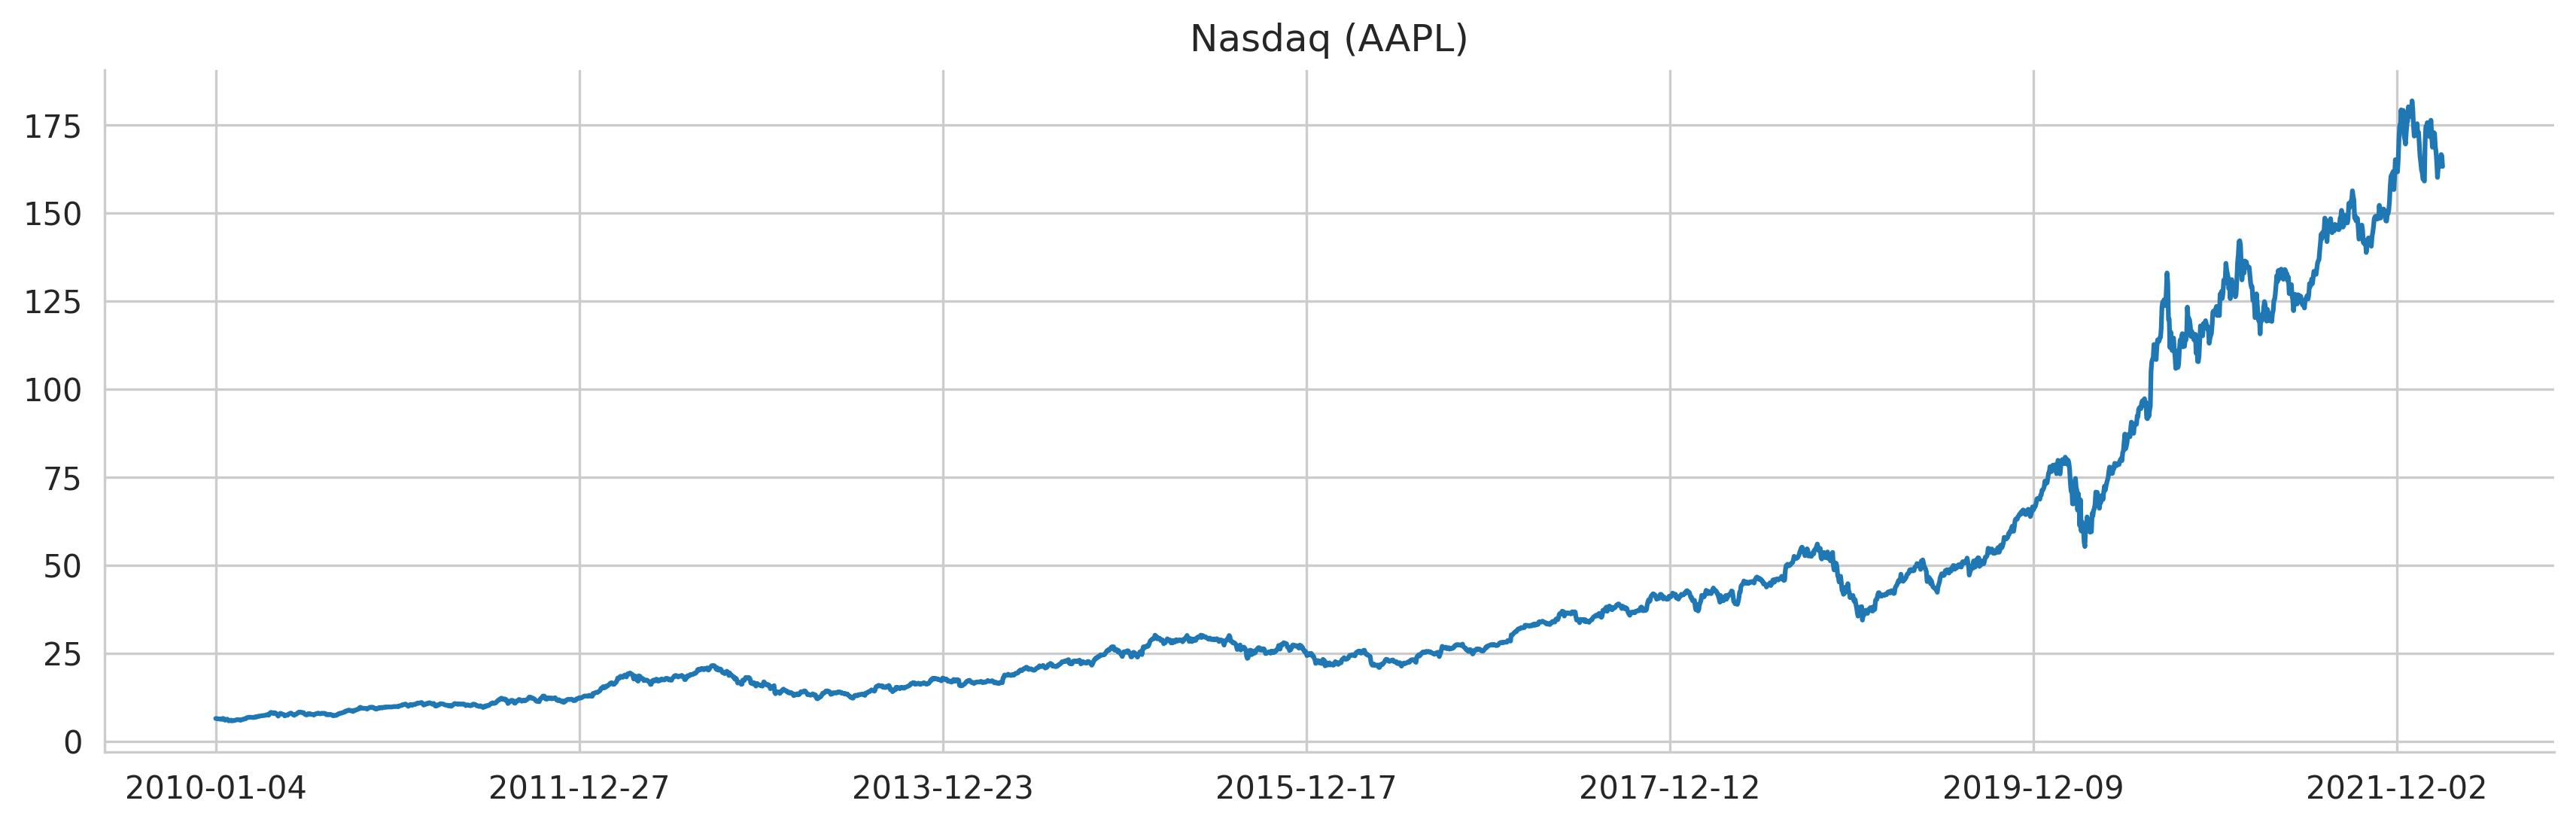

In [113]:
# sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()

sp500 = pd.read_csv("/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL.csv", low_memory=False)

sp500.set_index("date", inplace=True)
sp500 = sp500[["5. adjusted close"]]

sp500.sort_values(by=["date"], ascending=True, inplace=True)


sp500 = sp500[sp500.index>='2010-01-01']

df = sp500.copy()

df["adjusted_close_shift"] = df["5. adjusted close"].shift(-1)


ax = sp500["5. adjusted close"].plot(title='Nasdaq (AAPL)',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [114]:
sp500.shape

(3064, 1)

In [115]:
sp500

,5. adjusted close
date,
2010-01-04,6.543876
2010-01-05,6.555190
2010-01-06,6.450921
2010-01-07,6.438996
2010-01-08,6.481804
...,...
2022-02-28,165.120000
2022-03-01,163.200000
2022-03-02,166.560000


## Preprocessing

In [116]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

In [117]:
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), 
                         index=sp500.index)
sp500_scaled.describe()

count    3064.000000
mean        0.209567
std         0.233957
min         0.000000
25%         0.059199
50%         0.115963
75%         0.242842
max         1.000000
dtype: float64

## Generating recurrent sequences from our time series

Our time series is a sequence of numbers indexed by time:

$$x_{0},x_{1},x_{2},...,x_{T}$$

where $\{x_t\}$ is the numerical value in period $t$ and  $T$ is the total length of the series. 

To apply a RNN for regression of classification, we use a sliding window to construct a rolling set of input/output pairs for our model to learn from as animated below.

<img src="../assets/timeseries_windowing.gif" width=600 height=600/>

We will generate sequences of 63 trading days, approximately three months, and use a single LSTM layer with 20 hidden units to predict the index value one timestep ahead. 
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

Our S&P 500 sample has 2,264 observations or time steps. We will create overlapping sequences using a window of 63 observations each.
For a simpler window of size T = 5, we obtain input-output pairs as shown in the following table:

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline  {\langle x_1,x_2,x_3,x_4,x_5\rangle} & { x_6} \\
\ {\langle x_{2},x_{3},x_{4},x_{5},x_{6} \rangle } & {x_{7} } \\
  {\vdots} & {\vdots}\\
 { \langle x_{T-5},x_{T-4},x_{T-3},x_{T-2},x_{T-1} \rangle } &  {x_{T}}
\end{array}$$

Generally speaking, for window size S, the relationship takes the form 

$$x_t = f( x_{t-1}, x_{t-2}, ..., x_{t-S}) \quad\forall t=S, S+1, ..., T$$

Each of the $T-S$ lagged input sequence or vector is of length S with a corresponding scalar output.

We can use the function create_univariate_rnn_data() to stack sequences selected using a rolling windows:

In [118]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

We apply this function to the rescaled stock index for a window_size=63 to obtain a two-dimensional dataset of shape number of samples x number of timesteps:

In [119]:
window_size = 63

In [120]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

In [121]:
X.shape, y.shape

((3001, 63), (3001,))

In [122]:
y.head()

date
2010-04-06    0.008255
2010-04-07    0.008439
2010-04-08    0.008326
2010-04-09    0.008646
2010-04-12    0.008733
dtype: float64

In [123]:
X.shape

(3001, 63)

In [124]:
y.shape

(3001,)

In [125]:
5602 - 63

5539

## Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2018.

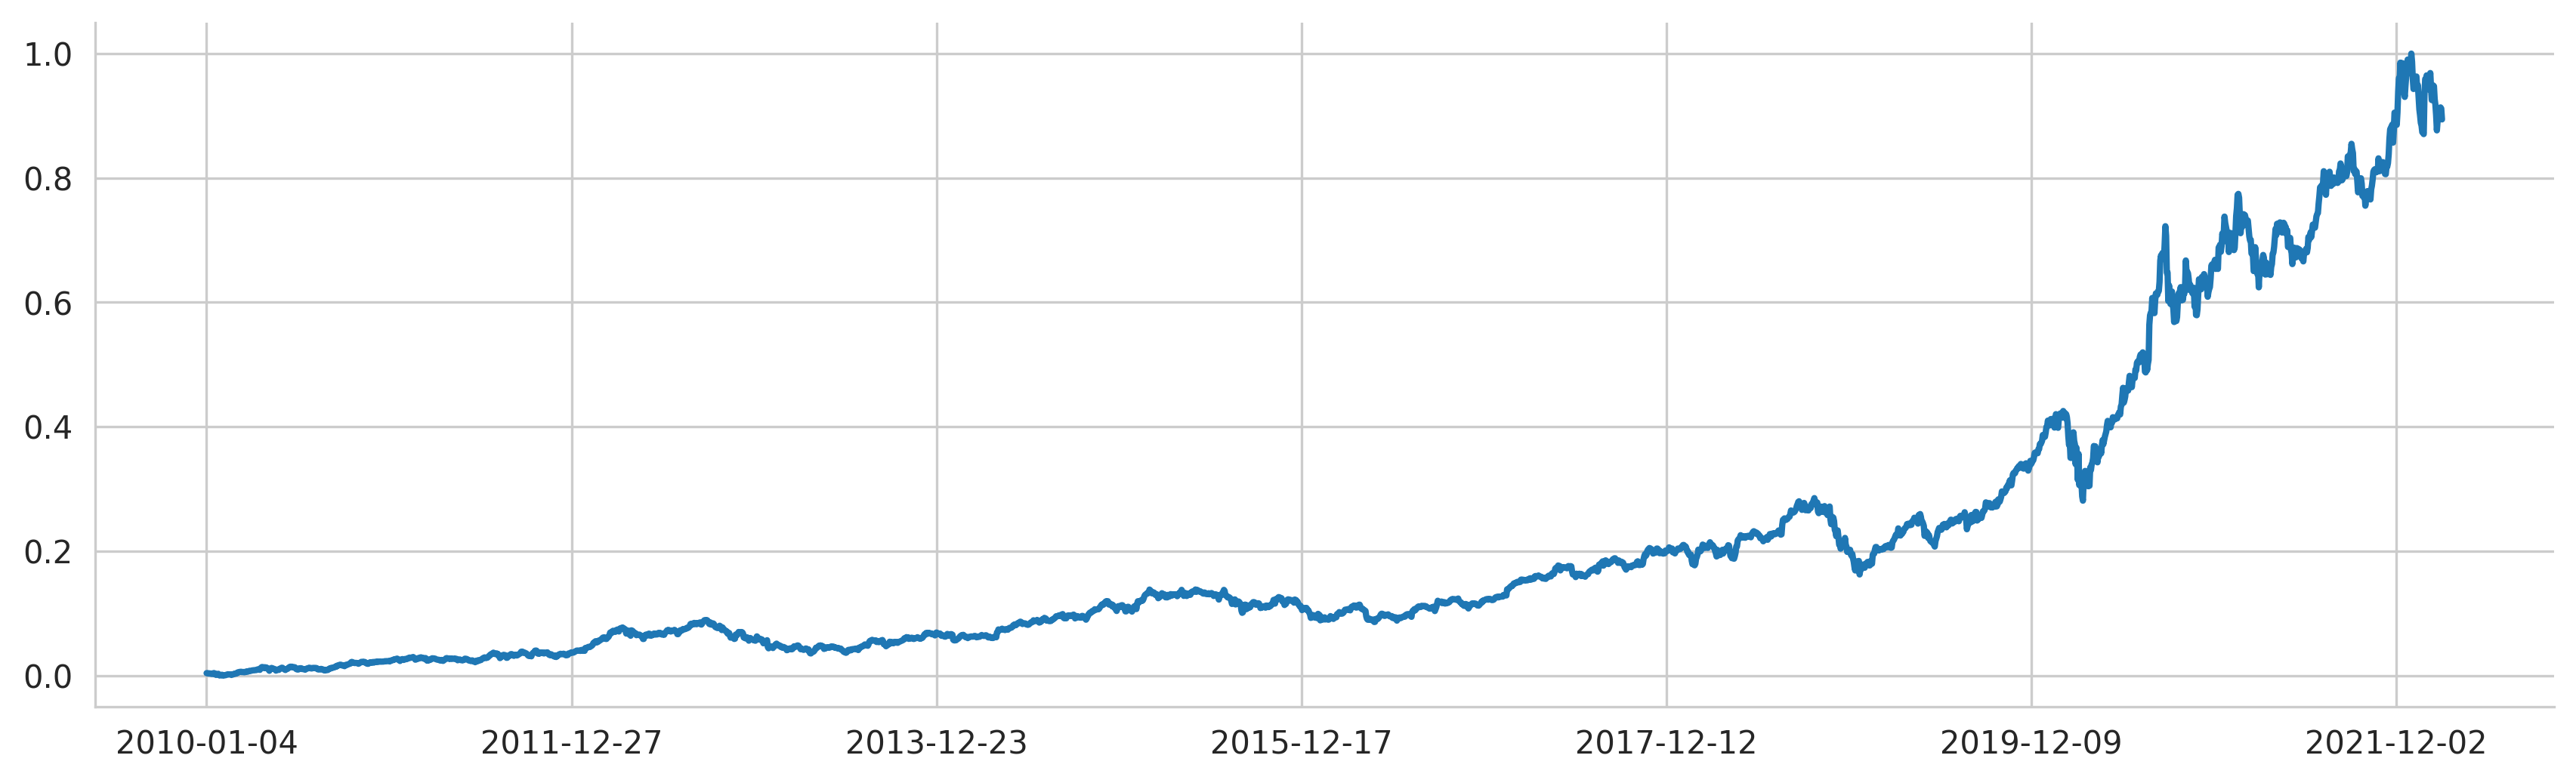

In [126]:
ax = sp500_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [127]:
split_time = int(len(X) * .9)

X_train = X[:split_time].values.reshape(-1, window_size, 1)
y_train = y[:split_time]
X_test = X[split_time:].values.reshape(-1, window_size, 1)
y_test = y[split_time:]

In [128]:
# X_test.hist()

In [129]:
### this code was taken from the Coursera coure on Sequences, Time Series and Prediction
time = np.arange(len(sp500_scaled), dtype="float32")  
time_train = time[:split_time]
time_test = time[split_time:]

In [130]:
X_train.shape

(2700, 63, 1)

In [131]:
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(2700, 63, 1)

In [132]:
X_test.shape

(301, 63, 1)

In [133]:
y_train.shape

(2700,)

In [134]:
len(X)

3001

In [135]:
type(X_test)

numpy.ndarray

In [136]:
y_test.shape

(301,)

In [137]:
type(y_test)

pandas.core.series.Series

## Keras LSTM Layer

Keras has several built-in RNN layers with various configuration options described in detail in the [documentation](https://keras.io/layers/recurrent/).

```
LSTM(units,
     activation='tanh',
     recurrent_activation='hard_sigmoid',
     use_bias=True,
     kernel_initializer='glorot_uniform',
     recurrent_initializer='orthogonal',
     bias_initializer='zeros',
     unit_forget_bias=True,
     kernel_regularizer=None,
     recurrent_regularizer=None,
     bias_regularizer=None,
     activity_regularizer=None,
     kernel_constraint=None,
     recurrent_constraint=None,
     bias_constraint=None,
     dropout=0.0,
     recurrent_dropout=0.0,
     implementation=1,
     return_sequences=False,
     return_state=False,
     go_backwards=False,
     stateful=False,
     unroll=False)
 ```

##  Define the Model Architecture

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 20 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LSTM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

In [138]:
rnn = Sequential([
    LSTM(units=63, 
         input_shape=(window_size, n_features), name='LSTM'),
#    Bidirectional(LSTM(63, input_shape=(window_size, n_features), return_sequences=True), name='LSTM1'),
#    tf.keras.layers.Dropout(0.20),
#    LSTM(units=63, 
#           input_shape=(window_size, n_features), name='LSTM2'),
   Dense(1, name='Output')
])

The summary shows that the model has 1,781 parameters:

In [139]:
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 63)                16380     
                                                                 
 Output (Dense)              (None, 1)                 64        
                                                                 
Total params: 16,444
Trainable params: 16,444
Non-trainable params: 0
_________________________________________________________________


## Train the Model

We train the model using the RMSProp optimizer recommended for RNN with default settings and compile the model with mean squared error for this regression problem:

In [140]:
optimizer = keras.optimizers.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [141]:
rnn.compile(loss='mean_absolute_error', 
            # metrics=['mean_absolute_error'],
            optimizer=optimizer)

We define an EarlyStopping callback and train the model for up to 100 episodes. 

In [142]:
rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [143]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              mode='min',  
                              restore_best_weights=True)

In [144]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=100,
                        batch_size=32,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/100
84/85 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 1: val_loss improved from inf to 0.05454, saving model to results/univariate_time_series/rnn.h5
85/85 [==============================] - 4s 22ms/step - loss: 0.0220 - val_loss: 0.0545
Epoch 2/100
84/85 [============================>.] - ETA: 0s - loss: 0.0115
Epoch 2: val_loss improved from 0.05454 to 0.01983, saving model to results/univariate_time_series/rnn.h5
85/85 [==============================] - 1s 17ms/step - loss: 0.0115 - val_loss: 0.0198
Epoch 3/100
84/85 [============================>.] - ETA: 0s - loss: 0.0102
Epoch 3: val_loss improved from 0.01983 to 0.01812, saving model to results/univariate_time_series/rnn.h5
85/85 [==============================] - 2s 20ms/step - loss: 0.0102 - val_loss: 0.0181
Epoch 4/100
85/85 [==============================] - ETA: 0s - loss: 0.0093
Epoch 4: val_loss did not improve from 0.01812
85/85 [==============================] - 2s 25ms/step - loss: 0.0093 - 

Training stops after 51 epochs; the `early_stopping` callback restores the weights for the best model (after 41 epochs)

## Evaluate model performance

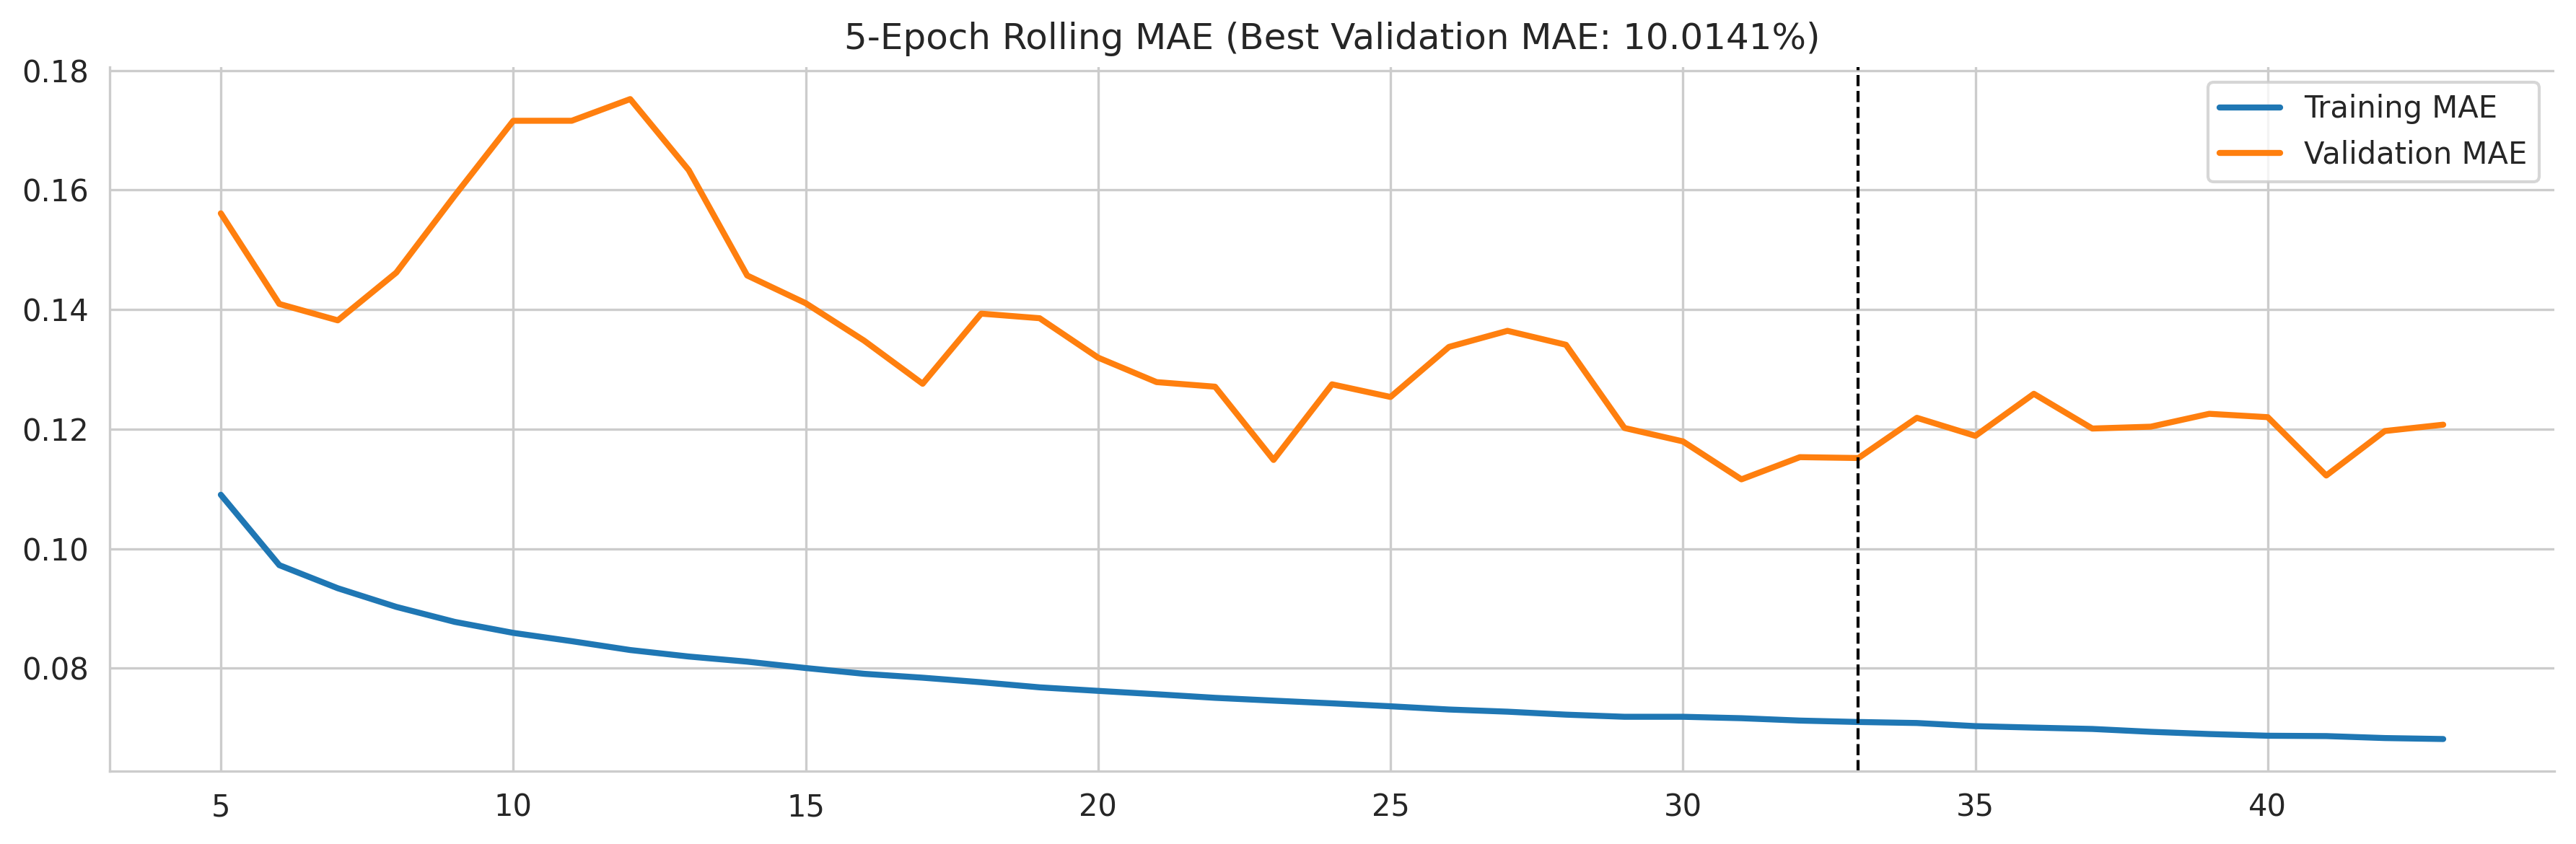

In [145]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling MAE (Best Validation MAE: {best_rmse:.4%})'
loss_history.columns=['Training MAE', 'Validation MAE']
# loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)
loss_history.rolling(5).mean().plot(logy=False, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300);

In [146]:
# forecast = []
# results = []
# for time in range(len(X) - window_size):
#   forecast.append(rnn.predict(X[time:time + window_size][np.newaxis]))

# forecast = forecast[split_time-window_size:]
# results = np.array(forecast)[:, 0, 0]


# plt.figure(figsize=(10, 6))

# plot_series(time_test, X_train)
# plot_series(time_test, results)

In [147]:
# Create a new model instance
# model = create_model()

# Restore the weights
# rnn.load_weights('../results/univariate_time_series/rnn.h5')
!pwd

/app/StockPricePredictions/src/exploratory_data_analysis/chance/python/samples/MachineLearningforAlgorithmicTrading/modified


In [148]:
train_mae_scaled = rnn.evaluate(X_train, y_train, verbose=0)
test_mae_scaled = rnn.evaluate(X_test, y_test, verbose=0)
print(f'Train MAE: {train_mae_scaled:.4f} | Test MAE: {test_mae_scaled:.4f}')

Train MAE: 0.0032 | Test MAE: 0.0100


In [149]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

In [150]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9994 | Test IC: 0.9870


### Rescale predictions

In [151]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), 
                          index=y_test.index))

In [152]:
sp500.tail()

,5. adjusted close
date,
2022-02-28,165.12
2022-03-01,163.20
2022-03-02,166.56
2022-03-03,166.23
2022-03-04,163.17


In [153]:
# 175.413620
# test_predict

(175.413620 - 172.90) / 172.90 * 100

1.4537998843262019

In [154]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [155]:
train_mse = mean_absolute_error(train_predict, y_train_rescaled)
test_mse = mean_absolute_error(test_predict, y_test_rescaled)
f'Train MAE: {train_mse:.4f} | Test MAE: {test_mse:.4f}'

'Train MAE: 0.5619 | Test MAE: 1.7640'

In [156]:
sp500['Train Predictions'] = train_predict
sp500['Test Predictions'] = test_predict
sp500 = sp500.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

### Plot Results

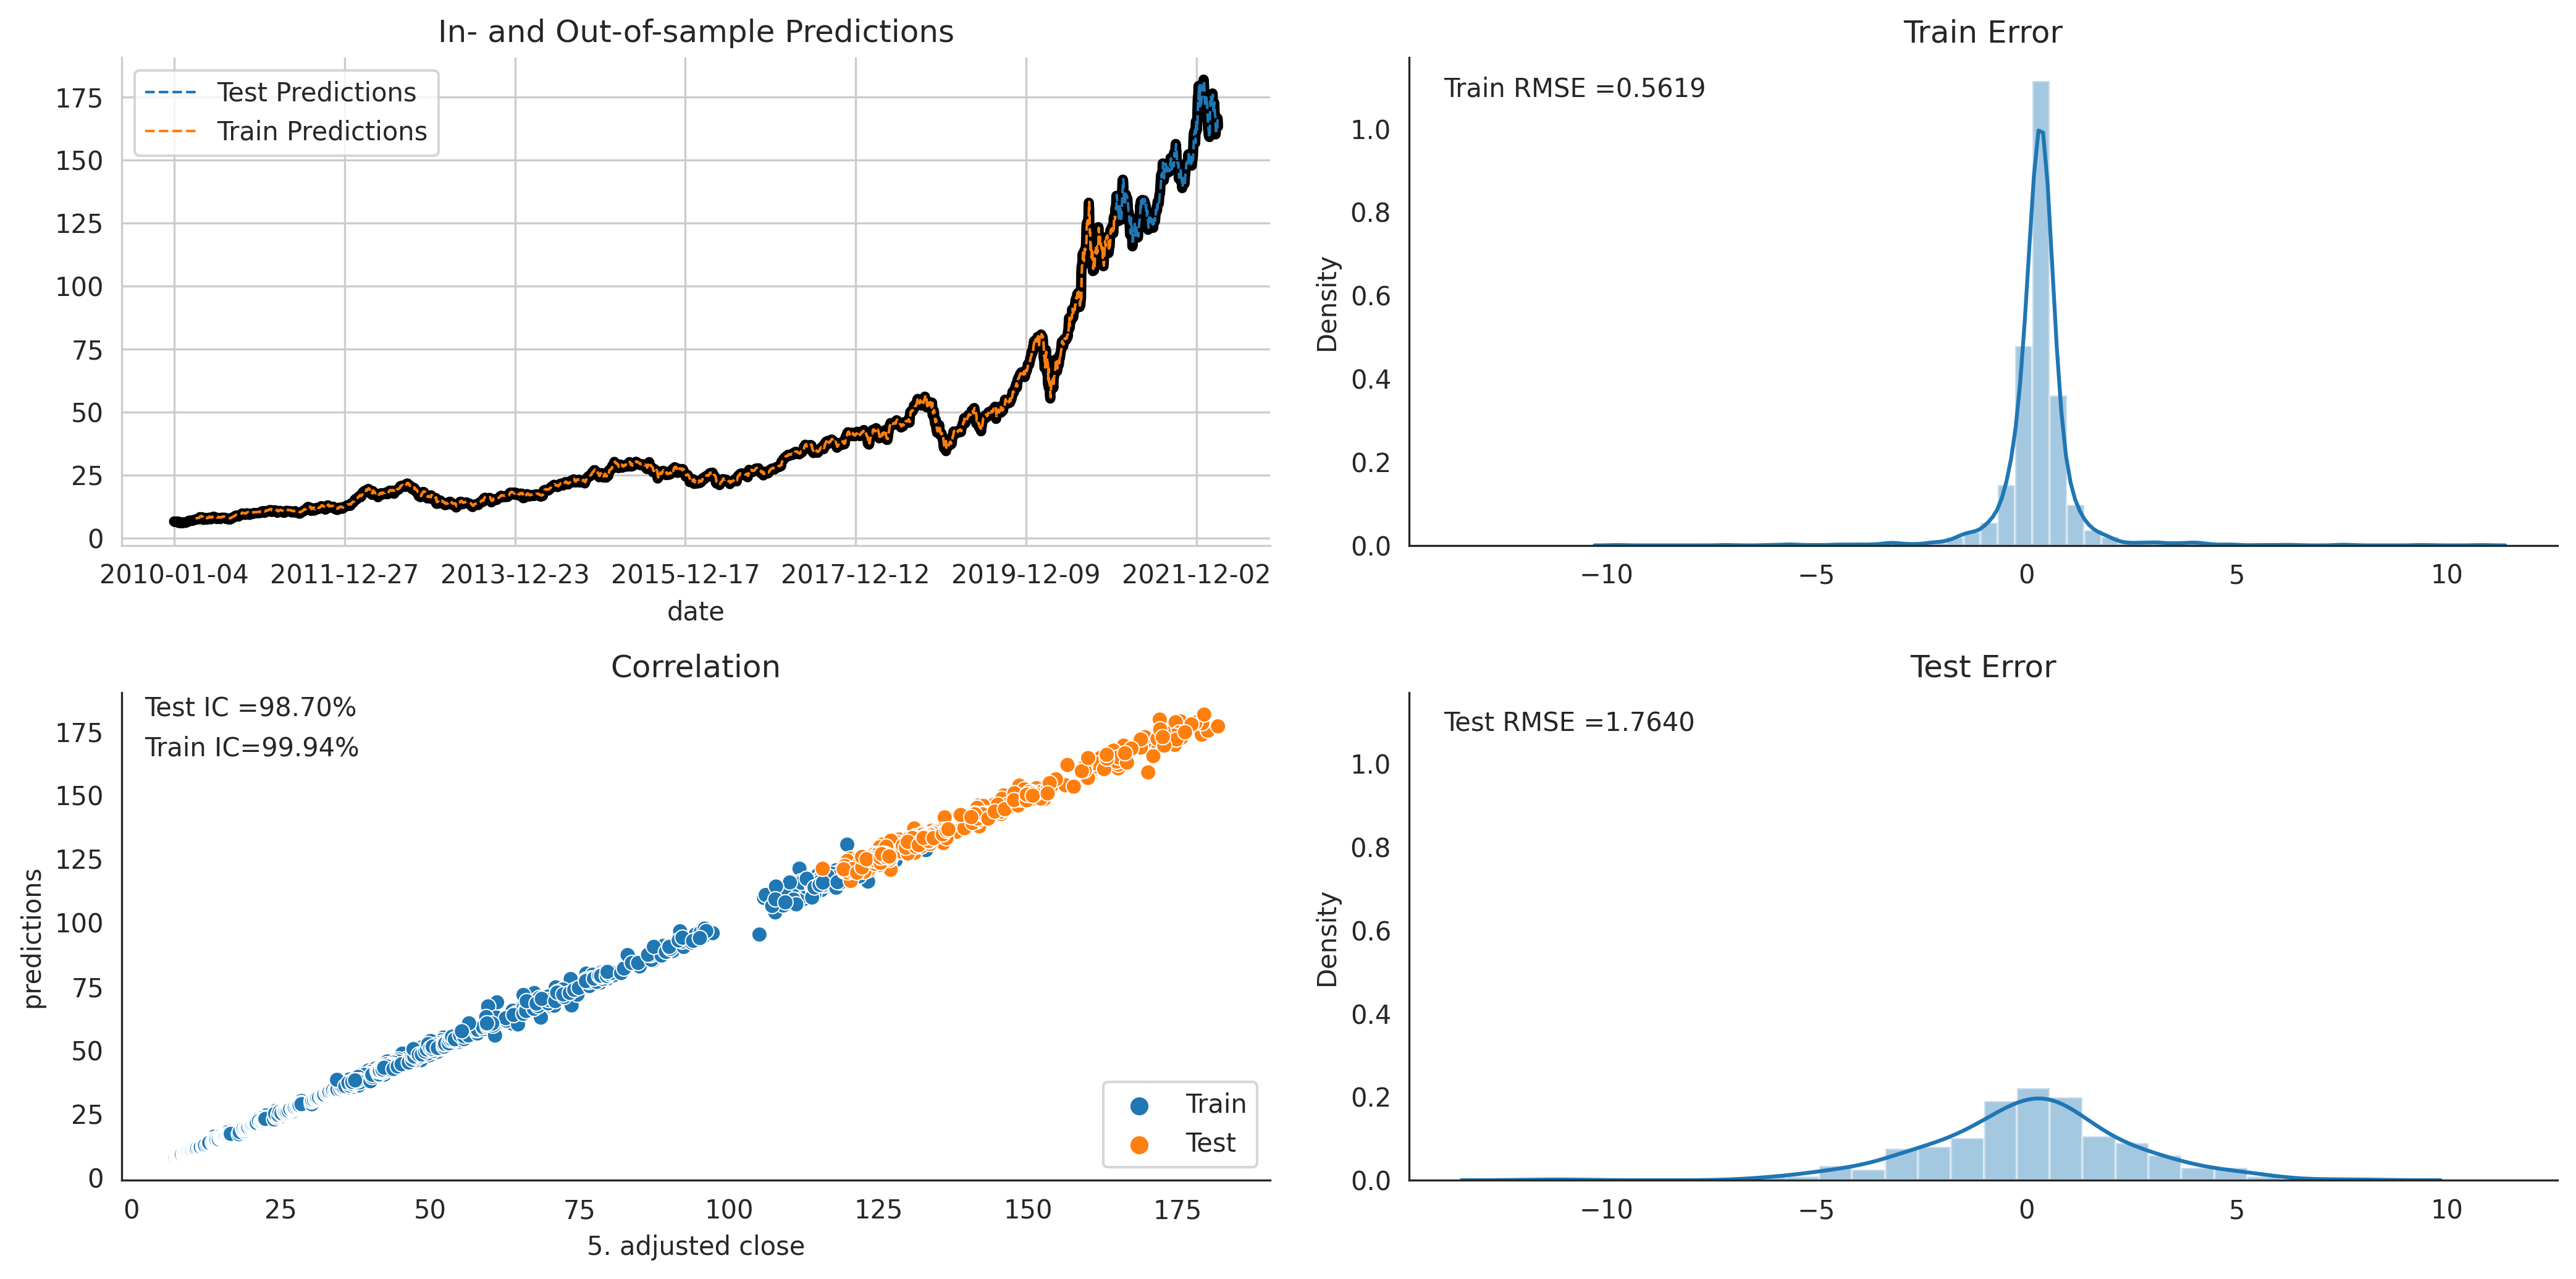

In [157]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

sp500.loc['1999-11-01':, '5. adjusted close'].plot(lw=4, ax=ax1, c='k')
sp500.loc['1999-11-01':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='5. adjusted close', y='predictions', data=sp500, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_mse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_mse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_regression', dpi=300);

# Prediction Step

Get last `X_test` value, which contains the last n actual values based on the defined `window_size`

In [158]:
X_test[-1:].shape

(1, 63, 1)

In [159]:
X_test[-1:]

array([[[0.89638342],
        [0.88548239],
        [0.90524051],
        [0.93851137],
        [0.96065409],
        [0.95770172],
        [0.98546529],
        [0.96440132],
        [0.95639587],
        [0.98461365],
        [0.9446432 ],
        [0.93828426],
        [0.93039237],
        [0.94878786],
        [0.96383355],
        [0.96746723],
        [0.9904616 ],
        [0.98455687],
        [0.98506786],
        [0.97836826],
        [0.97479136],
        [1.        ],
        [0.9868847 ],
        [0.95974567],
        [0.94316701],
        [0.94413221],
        [0.94424576],
        [0.96065409],
        [0.96320902],
        [0.94424576],
        [0.94924207],
        [0.93067625],
        [0.91040714],
        [0.90064163],
        [0.88871863],
        [0.88423331],
        [0.87378649],
        [0.8732755 ],
        [0.87060702],
        [0.93368539],
        [0.9589508 ],
        [0.95798561],
        [0.96496908],
        [0.94827687],
        [0.94663036],
        [0

In [160]:
valid_predict_scaled = rnn.predict(X_test[-1:])

In [161]:
valid_predict_scaled

array([[0.9092743]], dtype=float32)

In [162]:
valid_predict = pd.Series(scaler.inverse_transform(valid_predict_scaled).squeeze())

In [163]:
valid_predict

0    165.81885
dtype: object

In [164]:
sp500[sp500["data"]=="Test"].tail()

,5. adjusted close,Train Predictions,Test Predictions,predictions,data
date,,,,,
2022-02-28,165.12,NaN,164.809525,164.809525,Test
2022-03-01,163.20,NaN,164.313675,164.313675,Test
2022-03-02,166.56,NaN,162.780533,162.780533,Test
2022-03-03,166.23,NaN,166.444473,166.444473,Test
2022-03-04,163.17,NaN,165.818848,165.818848,Test


In [165]:
# sp500[sp500["data"]=="Test"]["5. adjusted close"].plot()

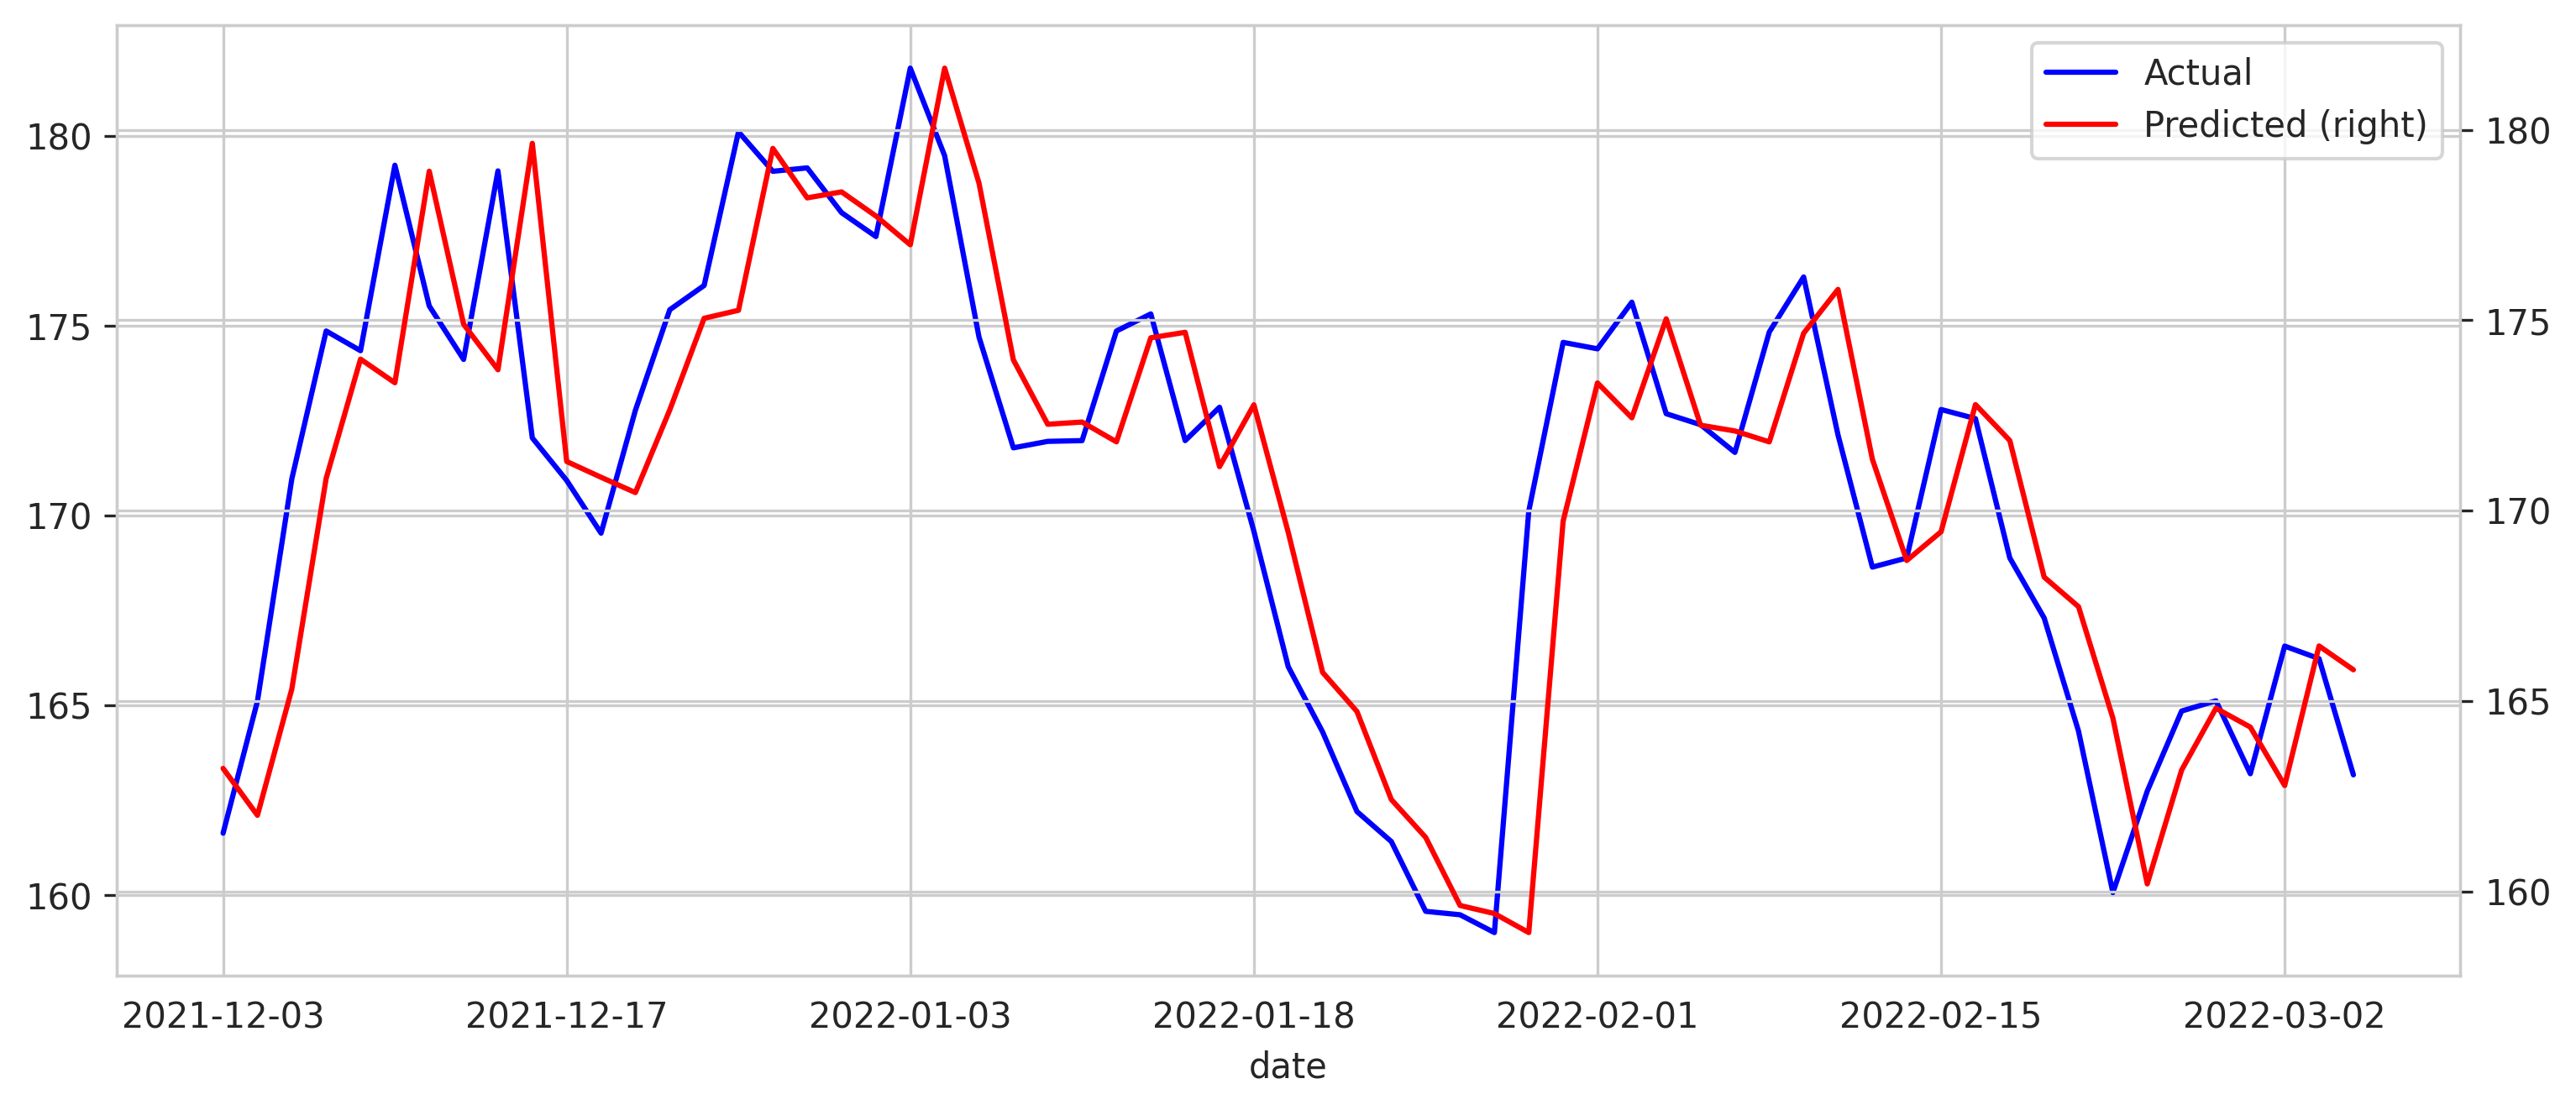

In [166]:
plt.figure(figsize=(12,5))

ax1 = sp500[sp500["data"]=="Test"][-63:]["5. adjusted close"].plot(color='blue', grid=True, secondary_y=False, label='Actual')
ax2 = sp500[sp500["data"]=="Test"][-63:]["Test Predictions"].plot(color='red', grid=True, secondary_y=True, label='Predicted')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

# plt.xlabel('Apple\'s Stock Price')
plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [167]:
h2, l2 = ax2.get_legend_handles_labels()

In [168]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['5. adjusted close'], df['adjusted_close_shift'], test_size=0.1, random_state=42, shuffle=False)

# X_train = df['[:split_time]
# y_train = df[:split_time]

# preds = np.array(df[split_time:]['5. adjusted close'])
# y = np.array(df[split_time:]['adjusted_close_shift'])

In [169]:
y_pred = X_test.tolist()

In [170]:
y_true = y_test.tolist()

In [171]:
y_true[:-1]

[126.865306215,
 127.748727876,
 125.718843272,
 127.28220183,
 130.90522325,
 129.992023331,
 130.994558025,
 135.679670656,
 133.873122989,
 132.731623089,
 131.709236223,
 128.453479988,
 130.041653761,
 125.664249799,
 129.952318986,
 131.073966713,
 128.026658286,
 127.847988737,
 129.922540728,
 127.957175684,
 126.200258447,
 126.885158387,
 131.054114541,
 135.858340205,
 138.042079143,
 141.863622285,
 142.101848351,
 141.009978882,
 136.076714099,
 130.984631939,
 133.148518705,
 133.992236022,
 132.949996983,
 136.374496681,
 135.952638023,
 136.101752499,
 135.207065644,
 134.590725811,
 134.33226072,
 134.570843881,
 132.4037135,
 130.067586713,
 128.944257663,
 129.103313103,
 125.256159629,
 125.116986118,
 124.609996901,
 120.275736139,
 120.544142195,
 127.035592373,
 124.381354705,
 121.339419399,
 119.420813145,
 120.703197636,
 115.673069321,
 120.370175307,
 119.271698669,
 121.240009749,
 120.315499999,
 123.258025654,
 124.828698132,
 124.023479963,
 119.81845174

In [172]:
# train_mse = mean_absolute_error(train_predict, y_train_rescaled)
test_mse = mean_absolute_error(y_true[:-1], y_pred[:-1])
f'Test MAE: {test_mse:.4f}'

'Test MAE: 1.7855'

In [173]:
df.head()

,5. adjusted close,adjusted_close_shift
date,,
2010-01-04,6.543876,6.555190
2010-01-05,6.555190,6.450921
2010-01-06,6.450921,6.438996
2010-01-07,6.438996,6.481804
2010-01-08,6.481804,6.424624


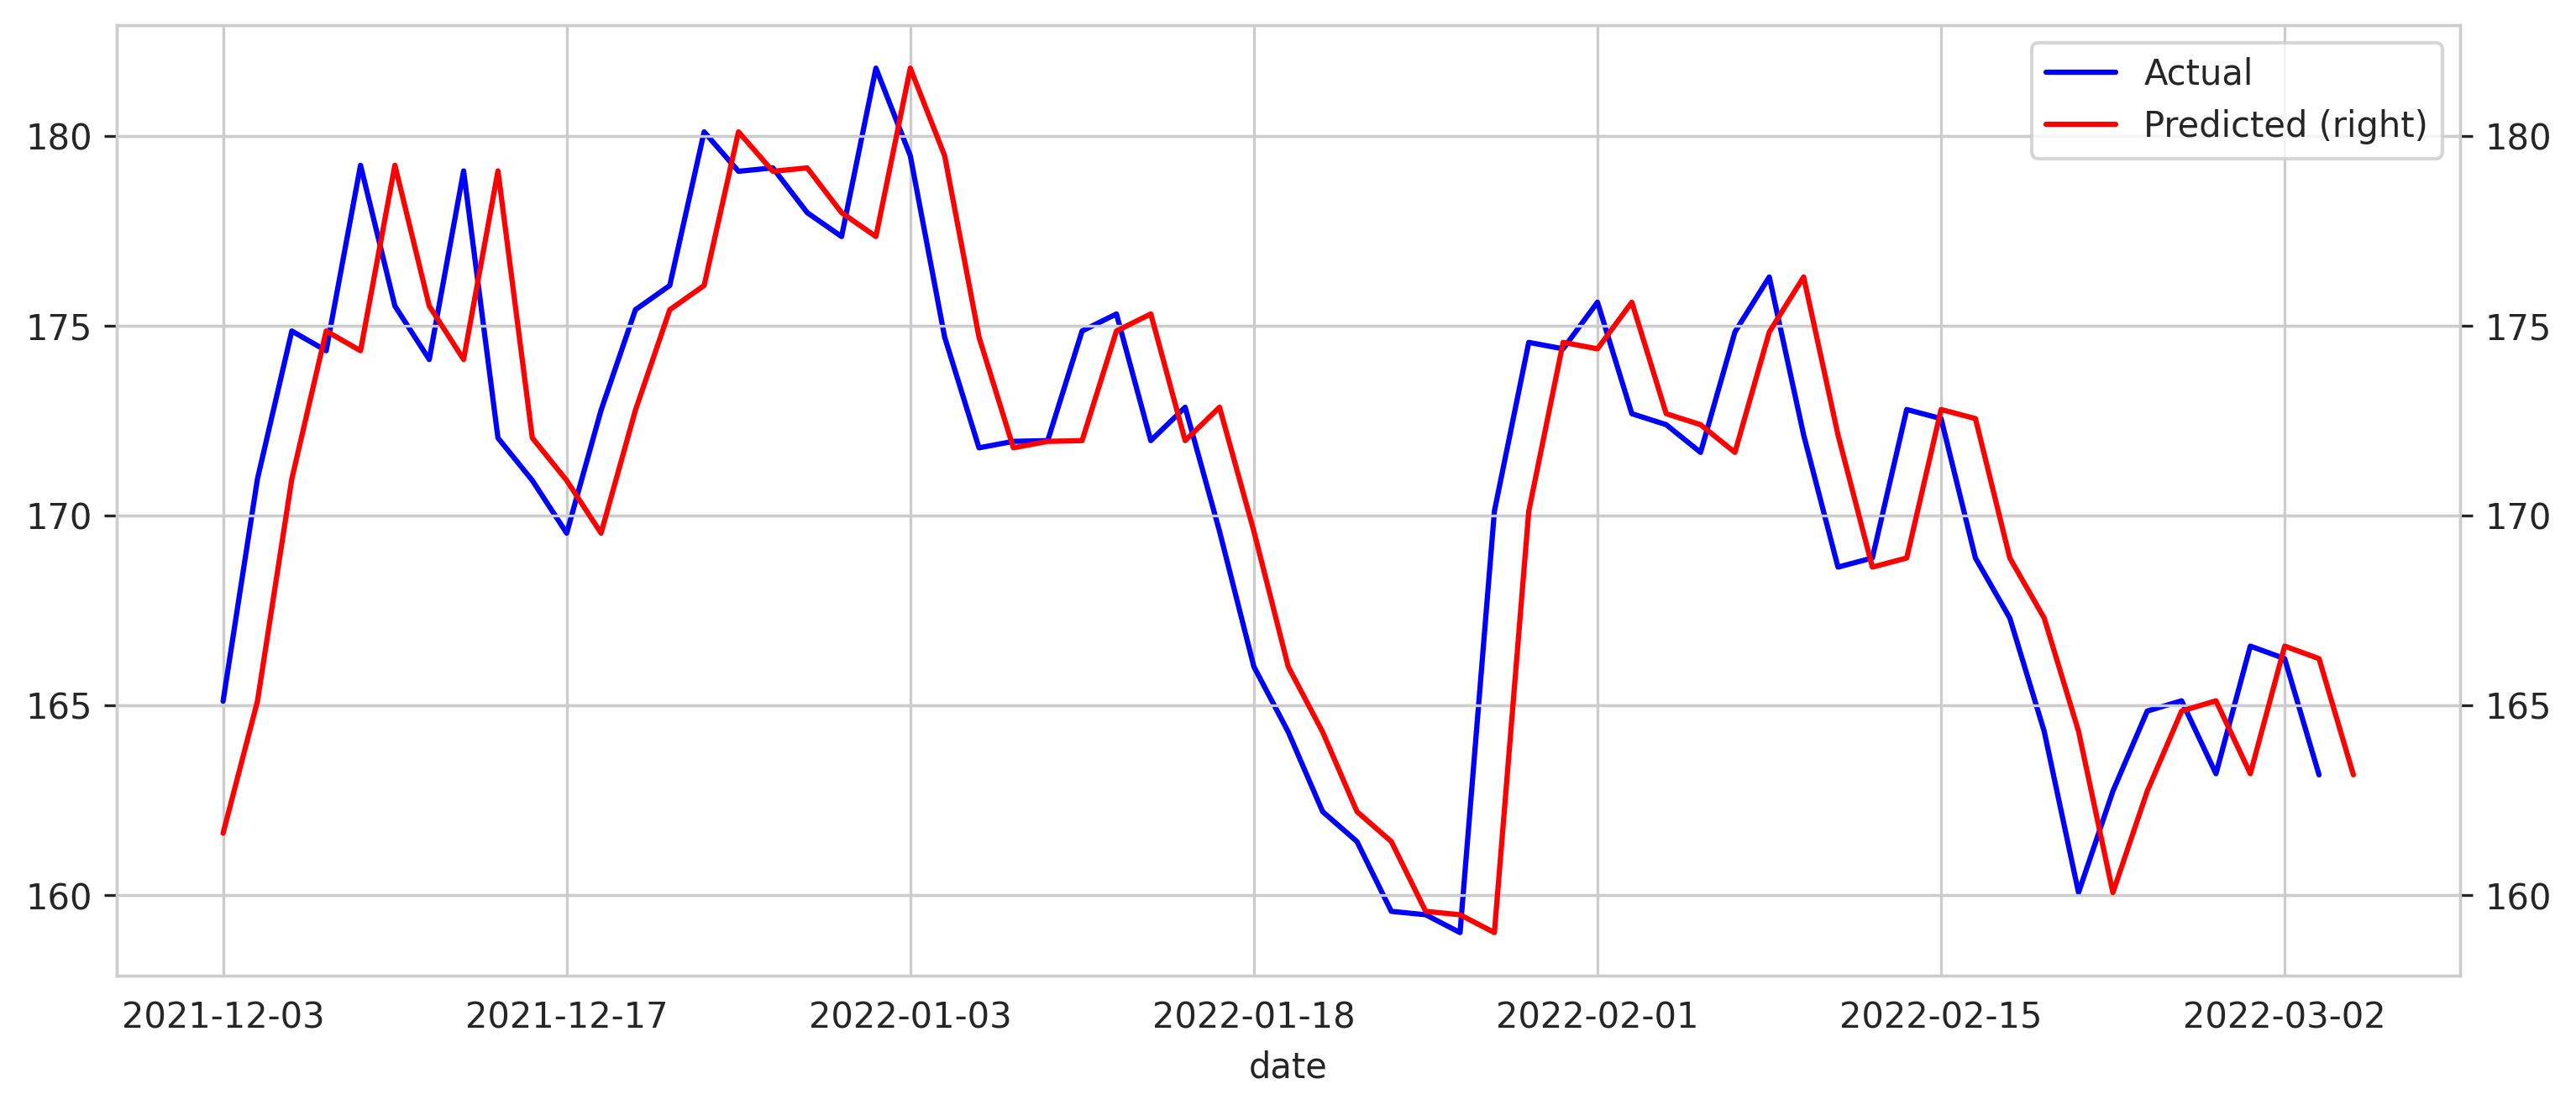

In [174]:
plt.figure(figsize=(12,5))

ax1 = df[-63:]["adjusted_close_shift"].plot(color='blue', grid=True, secondary_y=False, label='Actual')
ax2 = df[-63:]["5. adjusted close"].plot(color='red', grid=True, secondary_y=True, label='Predicted')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

# plt.xlabel('Apple\'s Stock Price')
plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

### Steps to predict next value

